### 作業目的: 實作word2vec Skip-gram模型
在課程中了解如何搭建CBOW模型，這次的作業目的在於透過搭建Skip-gram模型來了解另外一種word2vec的架構。

Hint_1: 學員可以善用課程中以搭建好的function模組
Hint_2: Skip_gram所需的輸入資料與目標跟CBOW有些許不同，Skip_gram是由中間字詞預測上下文

In [23]:
# import modules
import numpy as np
from typing import List
from utils.utility import clip_grads, convert_one_hot, preprocess, Trainer
from utils.layers import Dense, SoftmaxWithCrossEntropy
from utils.optimizer import SGD

In [24]:
# use the same corpus as in the lecture
text = "I am studying Natural Language Processing now."

# define create_contexts_target function
def create_contexts_target(corpus: List, window_size: int=1):

    ###<your code>###
    contexts = corpus[window_size:-window_size]
    targets = []

    for idx in range(window_size, len(corpus)-window_size):
        cs = []
        for t in range(-window_size, window_size + 1):
            if t == 0:
                # skip target word itself
                continue
            cs.append(corpus[idx + t])
        targets.append(cs)

    return np.array(contexts), np.array(targets)

# transform corpus to contexts and targets pair
corpus, word2idx, idx2word = preprocess([text])
contexts, targets= create_contexts_target(corpus[0], window_size=1)
contexts, targets

(array([0, 2, 6, 5, 4, 7]),
 array([[1, 2],
        [0, 6],
        [2, 5],
        [6, 4],
        [5, 7],
        [4, 3]]))

In [25]:
# transform contexts and targets to one-hot encoding
### <your code> ###
contexts = convert_one_hot(contexts, len(word2idx))
targets = convert_one_hot(targets, len(word2idx))
contexts , targets

(array([[1, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 1, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 1, 0],
        [0, 0, 0, 0, 0, 1, 0, 0],
        [0, 0, 0, 0, 1, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 1]]),
 array([[[0, 1, 0, 0, 0, 0, 0, 0],
         [0, 0, 1, 0, 0, 0, 0, 0]],
 
        [[1, 0, 0, 0, 0, 0, 0, 0],
         [0, 0, 0, 0, 0, 0, 1, 0]],
 
        [[0, 0, 1, 0, 0, 0, 0, 0],
         [0, 0, 0, 0, 0, 1, 0, 0]],
 
        [[0, 0, 0, 0, 0, 0, 1, 0],
         [0, 0, 0, 0, 1, 0, 0, 0]],
 
        [[0, 0, 0, 0, 0, 1, 0, 0],
         [0, 0, 0, 0, 0, 0, 0, 1]],
 
        [[0, 0, 0, 0, 1, 0, 0, 0],
         [0, 0, 0, 1, 0, 0, 0, 0]]]))

In [28]:
# define Skip-gram model
class SkipGram:
    def __init__(self, vocab_size, hidden_size, window_size):
        V, H = vocab_size, hidden_size
        self.window_size = window_size

        # initialize weights
        W_in = 0.01 * np.random.randn(V, H).astype('f')
        W_out = 0.01 * np.random.randn(H, V).astype('f')

        # create layers
        self.in_layer = Dense(W_in) ### <your code> ###
        self.out_layer = Dense(W_out) ### <your code> ###
        self.loss_layers = [SoftmaxWithCrossEntropy() for i in range(window_size*2)] ### <your code> ###
        

        layers = [self.in_layer , self.out_layer] ### <your code> ###
        self.params, self.grads = [], []
        for layer in layers:
            self.params += layer.params
            self.grads += layer.grads
        
        # word vector matrix
        self.word_vecs = W_in ### <your code> ###

    def forward(self, contexts, targets):
        h = self.in_layer.forward(contexts) ### <your code> ###
        s = self.out_layer.forward(h) ### <your code> ###
        
        loss = sum([self.loss_layers[i].forward(s, targets[:, i]) for i in range(self.window_size*2)]) ### <your code> ###
        return loss

    def backward(self, dout=1):
        
        ds = sum([self.loss_layers[i].backward(dout) for i in range(self.window_size*2)]) ### <your code> ###
        dh = self.out_layer.backward(ds) ### <your code> ###
        self.in_layer.backward(dh)
        
        return None

In [29]:
# start training

# configurations
window_size = 1
hidden_size = 5
batch_size = 3
max_epoch = 1000

# define model
skip_gram = SkipGram(vocab_size=len(word2idx), hidden_size=hidden_size, window_size=window_size) ### <your code> ###
sgd_optimizer = SGD()
trainer = Trainer(skip_gram, sgd_optimizer)

# start training
trainer.fit(contexts, targets, max_epoch, batch_size)

 22%|████████▎                             | 219/1000 [00:00<00:00, 986.54it/s]

Epoch: 1, Iteration: 1/2, Loss: 4.1589232163140775
Epoch: 2, Iteration: 1/2, Loss: 4.159081301941605
Epoch: 3, Iteration: 1/2, Loss: 4.158842138951027
Epoch: 4, Iteration: 1/2, Loss: 4.158957258878937
Epoch: 5, Iteration: 1/2, Loss: 4.158970815613211
Epoch: 6, Iteration: 1/2, Loss: 4.158754707578931
Epoch: 7, Iteration: 1/2, Loss: 4.158801184732305
Epoch: 8, Iteration: 1/2, Loss: 4.158763427555511
Epoch: 9, Iteration: 1/2, Loss: 4.158707384029009
Epoch: 10, Iteration: 1/2, Loss: 4.158645297819965
Epoch: 11, Iteration: 1/2, Loss: 4.158658834849007
Epoch: 12, Iteration: 1/2, Loss: 4.1585202062703175
Epoch: 13, Iteration: 1/2, Loss: 4.158645328049097
Epoch: 14, Iteration: 1/2, Loss: 4.158470273689979
Epoch: 15, Iteration: 1/2, Loss: 4.158352575816524
Epoch: 16, Iteration: 1/2, Loss: 4.158290985298649
Epoch: 17, Iteration: 1/2, Loss: 4.158209382438979
Epoch: 18, Iteration: 1/2, Loss: 4.158486756265215
Epoch: 19, Iteration: 1/2, Loss: 4.157998143447827
Epoch: 20, Iteration: 1/2, Loss: 4.157

 44%|████████████████▎                    | 442/1000 [00:00<00:00, 1043.62it/s]

Epoch: 227, Iteration: 1/2, Loss: 1.4469367643334015
Epoch: 228, Iteration: 1/2, Loss: 1.4403495963599429
Epoch: 229, Iteration: 1/2, Loss: 1.4361199387239996
Epoch: 230, Iteration: 1/2, Loss: 1.4496600523249263
Epoch: 231, Iteration: 1/2, Loss: 1.4386090541706973
Epoch: 232, Iteration: 1/2, Loss: 1.4306327471995144
Epoch: 233, Iteration: 1/2, Loss: 1.442144726730592
Epoch: 234, Iteration: 1/2, Loss: 1.4333937922072806
Epoch: 235, Iteration: 1/2, Loss: 1.4413048274017162
Epoch: 236, Iteration: 1/2, Loss: 1.43547299879175
Epoch: 237, Iteration: 1/2, Loss: 1.4314813249948386
Epoch: 238, Iteration: 1/2, Loss: 1.438875473428746
Epoch: 239, Iteration: 1/2, Loss: 1.4347587691609869
Epoch: 240, Iteration: 1/2, Loss: 1.4305633303794516
Epoch: 241, Iteration: 1/2, Loss: 1.4418961591142736
Epoch: 242, Iteration: 1/2, Loss: 1.4282407025830712
Epoch: 243, Iteration: 1/2, Loss: 1.4367053196506463
Epoch: 244, Iteration: 1/2, Loss: 1.4293349936969477
Epoch: 245, Iteration: 1/2, Loss: 1.43144699089196

 57%|█████████████████████                | 569/1000 [00:00<00:00, 1102.58it/s]

Epoch: 444, Iteration: 1/2, Loss: 1.4003212296153915
Epoch: 445, Iteration: 1/2, Loss: 1.3995159959779992
Epoch: 446, Iteration: 1/2, Loss: 1.3992226701432355
Epoch: 447, Iteration: 1/2, Loss: 1.399302804770735
Epoch: 448, Iteration: 1/2, Loss: 1.398538749939086
Epoch: 449, Iteration: 1/2, Loss: 1.4000221396456989
Epoch: 450, Iteration: 1/2, Loss: 1.3999769004761276
Epoch: 451, Iteration: 1/2, Loss: 1.3974299427173915
Epoch: 452, Iteration: 1/2, Loss: 1.3988982496417022
Epoch: 453, Iteration: 1/2, Loss: 1.399832132914614
Epoch: 454, Iteration: 1/2, Loss: 1.399222729073459
Epoch: 455, Iteration: 1/2, Loss: 1.3995753090891188
Epoch: 456, Iteration: 1/2, Loss: 1.3980230844935613
Epoch: 457, Iteration: 1/2, Loss: 1.3989165400610486
Epoch: 458, Iteration: 1/2, Loss: 1.398492683707643
Epoch: 459, Iteration: 1/2, Loss: 1.3988211265122756
Epoch: 460, Iteration: 1/2, Loss: 1.3986963641368975
Epoch: 461, Iteration: 1/2, Loss: 1.3984889198535218
Epoch: 462, Iteration: 1/2, Loss: 1.398570126105671

 79%|█████████████████████████████▏       | 789/1000 [00:00<00:00, 1064.33it/s]

Epoch: 687, Iteration: 1/2, Loss: 1.3927887701391914
Epoch: 688, Iteration: 1/2, Loss: 1.3927341270668734
Epoch: 689, Iteration: 1/2, Loss: 1.3927923588961193
Epoch: 690, Iteration: 1/2, Loss: 1.3931318213586557
Epoch: 691, Iteration: 1/2, Loss: 1.392321316310859
Epoch: 692, Iteration: 1/2, Loss: 1.3927919052098332
Epoch: 693, Iteration: 1/2, Loss: 1.3930304035697065
Epoch: 694, Iteration: 1/2, Loss: 1.392241158894584
Epoch: 695, Iteration: 1/2, Loss: 1.3923034278632331
Epoch: 696, Iteration: 1/2, Loss: 1.3931427585532368
Epoch: 697, Iteration: 1/2, Loss: 1.3926231408328364
Epoch: 698, Iteration: 1/2, Loss: 1.3927159415641936
Epoch: 699, Iteration: 1/2, Loss: 1.3922042297931112
Epoch: 700, Iteration: 1/2, Loss: 1.3929053833480651
Epoch: 701, Iteration: 1/2, Loss: 1.3925871611698617
Epoch: 702, Iteration: 1/2, Loss: 1.3922534773614959
Epoch: 703, Iteration: 1/2, Loss: 1.3925762698844986
Epoch: 704, Iteration: 1/2, Loss: 1.3932864716813285
Epoch: 705, Iteration: 1/2, Loss: 1.392136267214

100%|████████████████████████████████████| 1000/1000 [00:00<00:00, 1127.40it/s]


Epoch: 913, Iteration: 1/2, Loss: 1.3906246950795649
Epoch: 914, Iteration: 1/2, Loss: 1.390370225317966
Epoch: 915, Iteration: 1/2, Loss: 1.3908338849837132
Epoch: 916, Iteration: 1/2, Loss: 1.3903010769419604
Epoch: 917, Iteration: 1/2, Loss: 1.3905441574489308
Epoch: 918, Iteration: 1/2, Loss: 1.3907555793624662
Epoch: 919, Iteration: 1/2, Loss: 1.3902919603813109
Epoch: 920, Iteration: 1/2, Loss: 1.3903072878160676
Epoch: 921, Iteration: 1/2, Loss: 1.3907715000629983
Epoch: 922, Iteration: 1/2, Loss: 1.3906340539152144
Epoch: 923, Iteration: 1/2, Loss: 1.390410059573519
Epoch: 924, Iteration: 1/2, Loss: 1.3902918630356815
Epoch: 925, Iteration: 1/2, Loss: 1.390566630958871
Epoch: 926, Iteration: 1/2, Loss: 1.3907024755816348
Epoch: 927, Iteration: 1/2, Loss: 1.3905890343377085
Epoch: 928, Iteration: 1/2, Loss: 1.3901936538130042
Epoch: 929, Iteration: 1/2, Loss: 1.3907441959696643
Epoch: 930, Iteration: 1/2, Loss: 1.3906835746172712
Epoch: 931, Iteration: 1/2, Loss: 1.390444950693

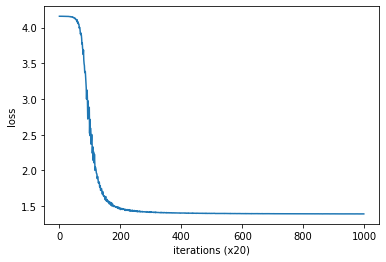

In [30]:
trainer.plot()

In [36]:
# check skip-gram results
### <your code> ###
word_vecs = skip_gram.word_vecs
for word_id, word in idx2word.items():
    print(word_id, word, word_vecs[word_id])

0 am [ 0.53572756 -2.2233667  -1.1826382  -0.6290156  -1.0183727 ]
1 i [ 0.01425028 -0.01052956 -0.00406308  0.00380864  0.00675842]
2 studying [-0.7869051   1.3618098  -0.16281328  0.40391758 -2.3052213 ]
3 . [ 0.00179054 -0.01607007  0.00771282  0.01456084  0.01127212]
4 processing [-1.2712989  0.5871648  1.592158  -1.1276559  1.4846514]
5 language [ 1.152474   1.6932524 -0.4447889  2.291982  -0.6203123]
6 natural [-0.7921553  -0.9477937  -0.08786593 -2.8920374   0.02463147]
7 now [ 1.2955494  -0.20403956 -0.10508148  1.6701022   1.9023067 ]
